In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# ARMA to ARIMA
integration adds the differenciation

lets work again on johnson2 dataset

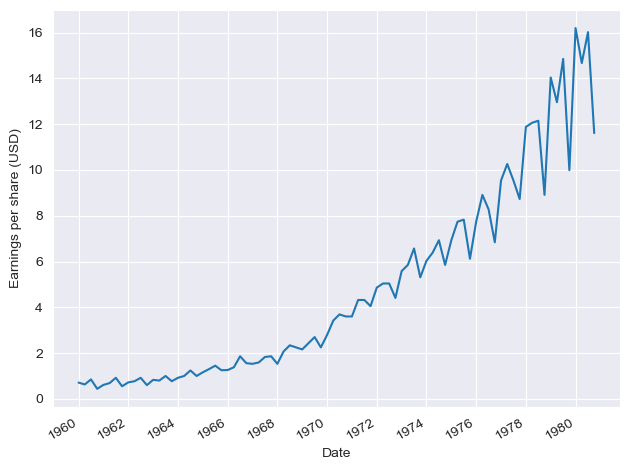

In [2]:
df = pd.read_csv('../data/jj.csv')
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

the original serie is not stationary, first differentiation is not either, but second is. the second can be found by np.diff(n=2) or twice np.diff(n=1) (does the same) 

ADF Statistic: 2.742016573457476
p-value: 1.0
ADF Statistic diff1: -0.4074097636380299
p-value diff1: 0.9088542416911333
ADF Statistic diff2: -3.585162874793185
p-value diff2: 0.006051099869603092


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

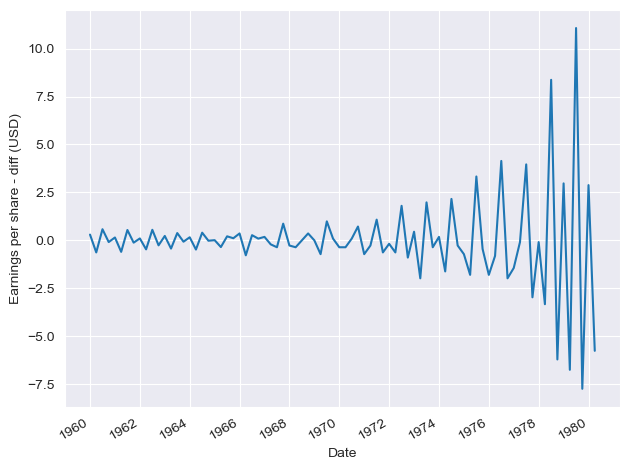

In [3]:
ad_fuller_result = adfuller(df['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

eps_diff = np.diff(df['data'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic diff1: {ad_fuller_result[0]}')
print(f'p-value diff1: {ad_fuller_result[1]}')

eps_diff2 = np.diff(eps_diff, n=1)
ad_fuller_result = adfuller(eps_diff2)
print(f'ADF Statistic diff2: {ad_fuller_result[0]}')
print(f'p-value diff2: {ad_fuller_result[1]}')



fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

eps_test = np.diff(df['data'], n=2)
fin= eps_test-eps_diff2
fin

let recall ARMA and add the differenciation parameter to make it arima

In [4]:
def optimize_ARMA(endogenous: Union[pd.Series, list], _order_list: list) -> pd.DataFrame:
    
    results = []
    
    #when using tqdm_notebook(order_list) instead of order_list, we have a progress bar 
    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try: 
            #p=order[0] and q=order[1]
            _model = SARIMAX(endogenous, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = _model.aic
        results.append([order, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df_local = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_local

def optimize_ARIMA(endog: Union[pd.Series, list], _order_list: list, _d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try: 
            _model = SARIMAX(endog, order=(order[0], _d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = _model.aic
        results.append([order, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df_local = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_local

as we can see, the results are the same on ARIMA with order two and ARMA on a differentiation of 2. but ARIMA is more practical since it immediately fits the model and doesn't need inverse transformation applied. in both cases (3,3) is the model 

In [5]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

train = df['data'][:-4]
result_df = optimize_ARIMA(train, order_list, d)
print(result_df)

train_arma = eps_test[:-4]
result_df_arma = optimize_ARMA(train_arma, order_list)
result_df_arma

  0%|          | 0/16 [00:00<?, ?it/s]

     (p,q)         AIC
0   (3, 3)  115.273275
1   (3, 1)  115.624980
2   (3, 2)  115.672007
3   (3, 0)  154.430620
4   (0, 3)  194.654716
5   (0, 2)  209.274664
6   (2, 3)  220.666799
7   (1, 3)  228.267772
8   (1, 2)  228.935871
9   (2, 2)  229.974680
10  (2, 1)  234.501112
11  (1, 1)  236.117220
12  (0, 1)  252.601006
13  (2, 0)  280.299907
14  (1, 0)  280.389386
15  (0, 0)  320.324435


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.270450
1,"(3, 1)",115.625005
2,"(3, 2)",115.672031
3,"(3, 0)",154.430739
4,"(0, 3)",194.654725
5,"(0, 2)",209.274485
6,"(2, 3)",220.666711
7,"(1, 3)",228.267628
8,"(1, 2)",228.935787
9,"(2, 2)",229.974642


In [6]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())


model_arma = SARIMAX(train_arma, order=(3,0,3), simple_differencing=False)
model_fit_arma = model_arma.fit(disp=False)

print(model_fit_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.637
Date:                Mon, 20 Nov 2023   AIC                            115.273
Time:                        00:45:18   BIC                            131.770
Sample:                             0   HQIC                           121.877
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      0.037    -26.833      0.000      -1.073      -0.927
ar.L2         -0.9878      0.040    -24.592      0.000      -1.066      -0.909
ar.L3         -0.9753      0.026    -37.147      0.0

residuals seem a random white gaussian noise (no auto-correlation on acf plot, failed acorr_ljungbox test, normal distribution)

      lb_stat  lb_pvalue
1    1.771456   0.183202
2    1.774778   0.411729
3    7.371850   0.060944
4    9.382996   0.052208
5   10.013983   0.074840
6   10.246830   0.114635
7   10.487154   0.162606
8   10.519949   0.230410
9   10.854948   0.285783
10  11.293674   0.335101


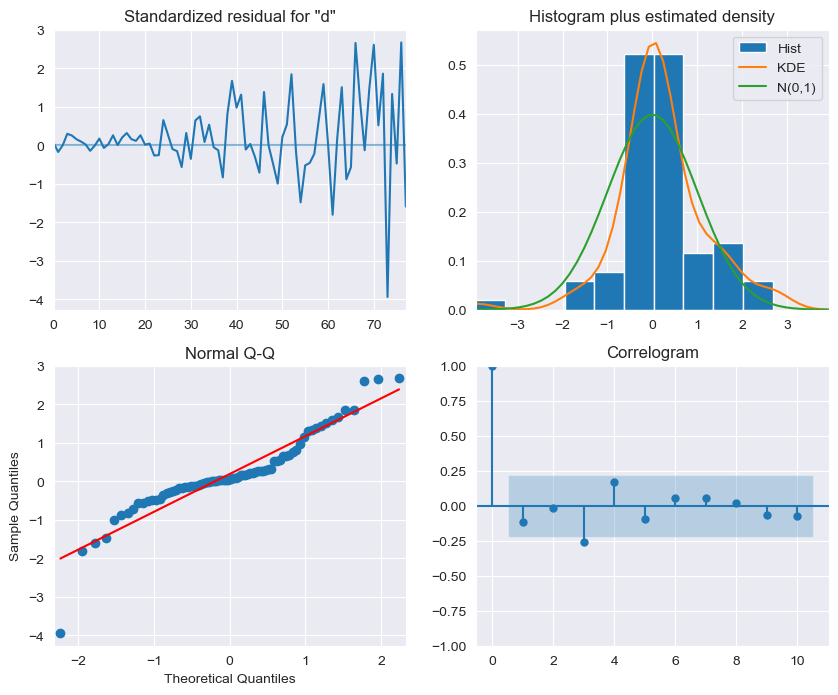

In [7]:
model_fit.plot_diagnostics(figsize=(10,8))
residuals = model_fit.resid
vals = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(vals)

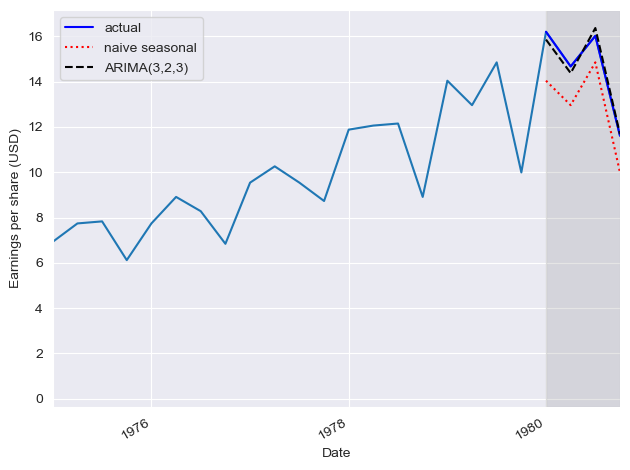

In [8]:
test = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[76:80].values
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

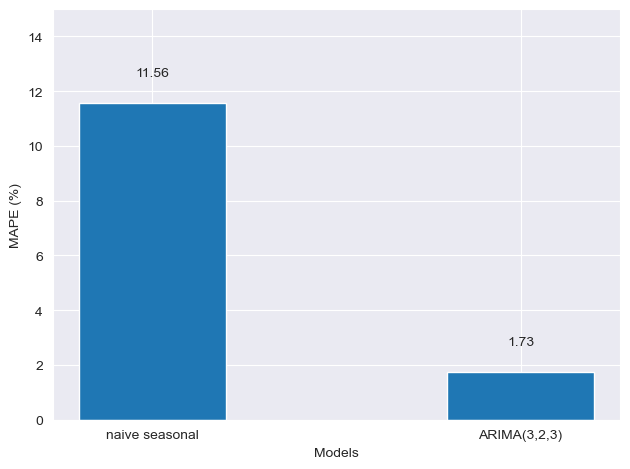

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

# ARIMA to SARIMA
let's take into account seasonality

we work here with a dataset showing the number of passengers in a flight company per date 

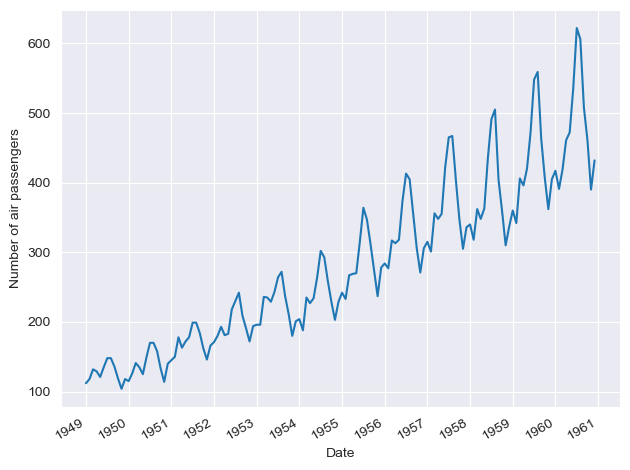

In [10]:
df = pd.read_csv('../data/air-passengers.csv')
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Assessing seasonality 
we can see seasonality but what are the different methods to assess seasonality 
you will have to differentiate or detrend before most of the analysis 
- Differencing removes trends by subtracting successive observations. This method is especially effective for time series with seasonal patterns and trends that are not strictly linear.
- Detrending specifically targets and removes linear trends from the data. It's more suitable when the trend component of the time series is linear or close to linear.
### ACF and PACF plots 
check if you observe regular spikes in these plots 
here, clearly, ACF brings a spike every 12 steps

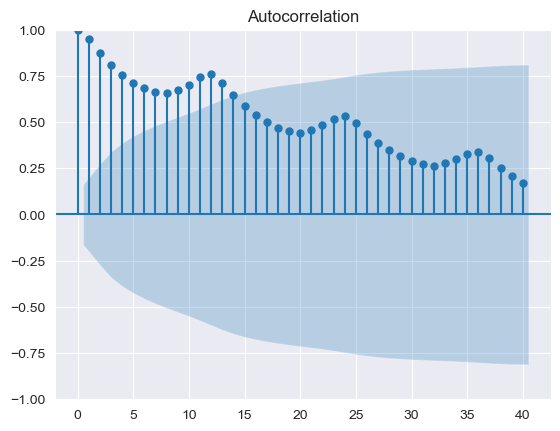

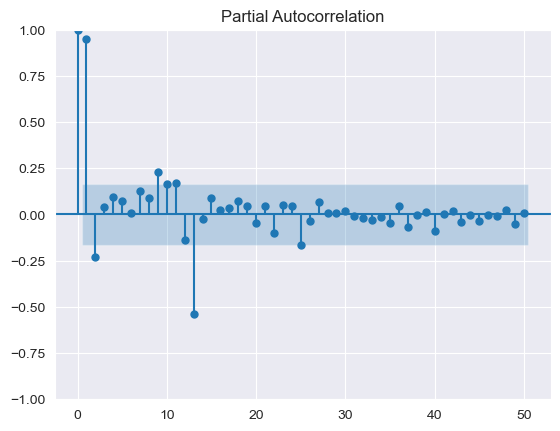

In [11]:
data= df.copy()
lag_acf = plot_acf(data['Passengers'], lags=40)
lag_pacf = plot_pacf(data['Passengers'], lags=50)

### Fourier transform and spectral analysis
can give you information, here we can see there is a light peak at 0.083 (1/12) indicating a 12point seasonality 

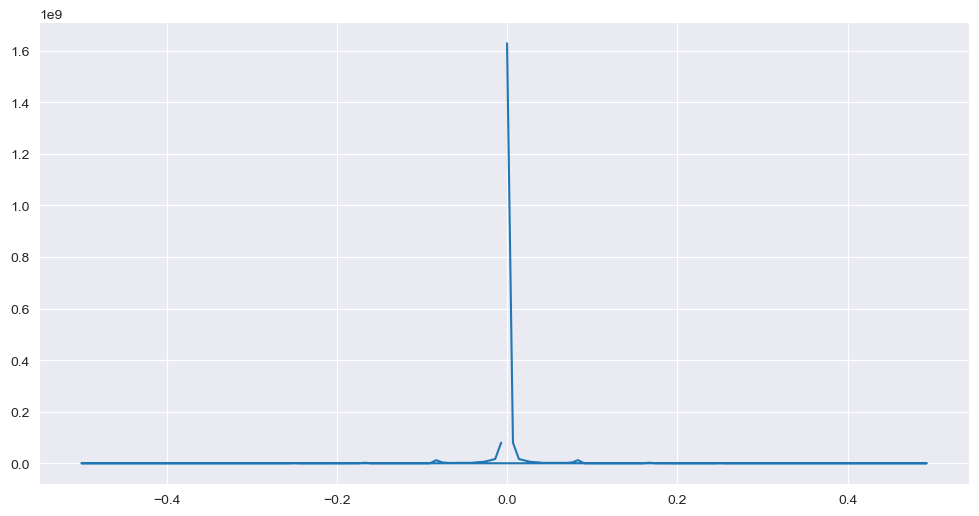

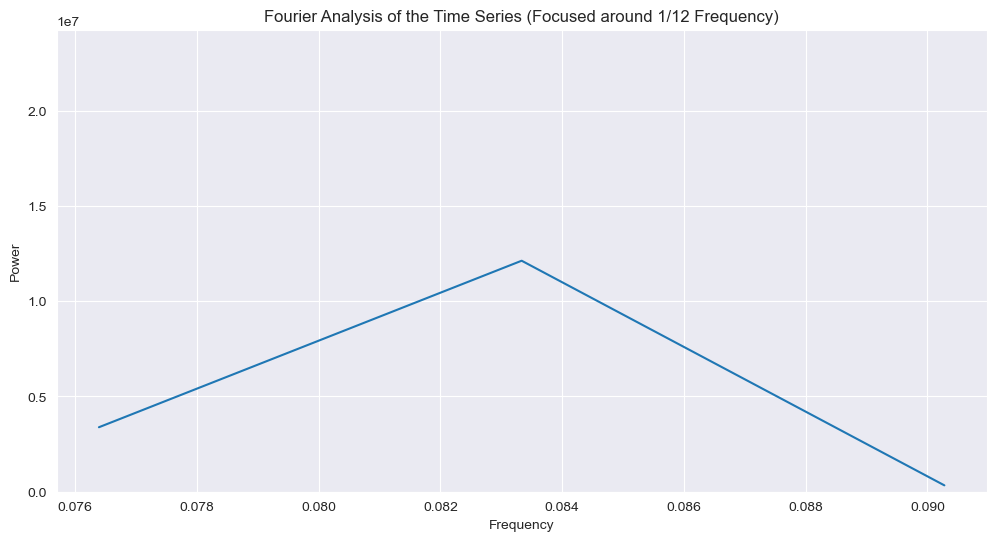

In [12]:
from scipy import fftpack
data= df.copy()
y = data['Passengers']
frequencies = fftpack.fftfreq(len(y))
power = np.abs(fftpack.fft(y))**2
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power)
plt.show()
frequencies_relevant_subset = frequencies[(frequencies >= 1/12 - 0.01) & (frequencies <= 1/12 + 0.01)]
power_relevant_subset = power[(frequencies >= 1/12 - 0.01) & (frequencies <= 1/12 + 0.01)]
y_max_relevant = power_relevant_subset.max()

plt.figure(figsize=(12, 6))
plt.plot(frequencies_relevant_subset, power_relevant_subset)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Fourier Analysis of the Time Series (Focused around 1/12 Frequency)')
plt.ylim(0, y_max_relevant * 2)  # Setting the y-axis to start from 0 and be twice as large
plt.grid(True)
plt.show()

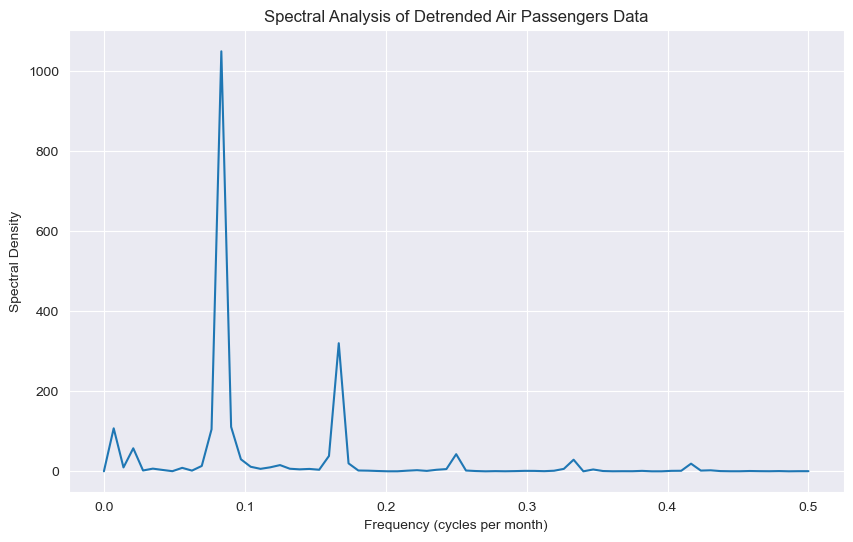

In [13]:
from scipy import signal
from scipy.signal import detrend
data= df.copy()
# Detrending the data
detrended_data = detrend(data['Passengers'])

# Perform a spectral analysis on the detrended data
frequencies_detrended, spectrum_detrended = signal.periodogram(detrended_data, fs=1, scaling='spectrum')

# Plotting the spectral density for the detrended data
plt.figure(figsize=(10, 6))
plt.plot(frequencies_detrended, spectrum_detrended)
plt.title('Spectral Analysis of Detrended Air Passengers Data')
plt.xlabel('Frequency (cycles per month)')
plt.ylabel('Spectral Density')
plt.grid(True)
plt.show()

### Plot seasonality
multiplicative is to use when the magnitude is proportional to the trend

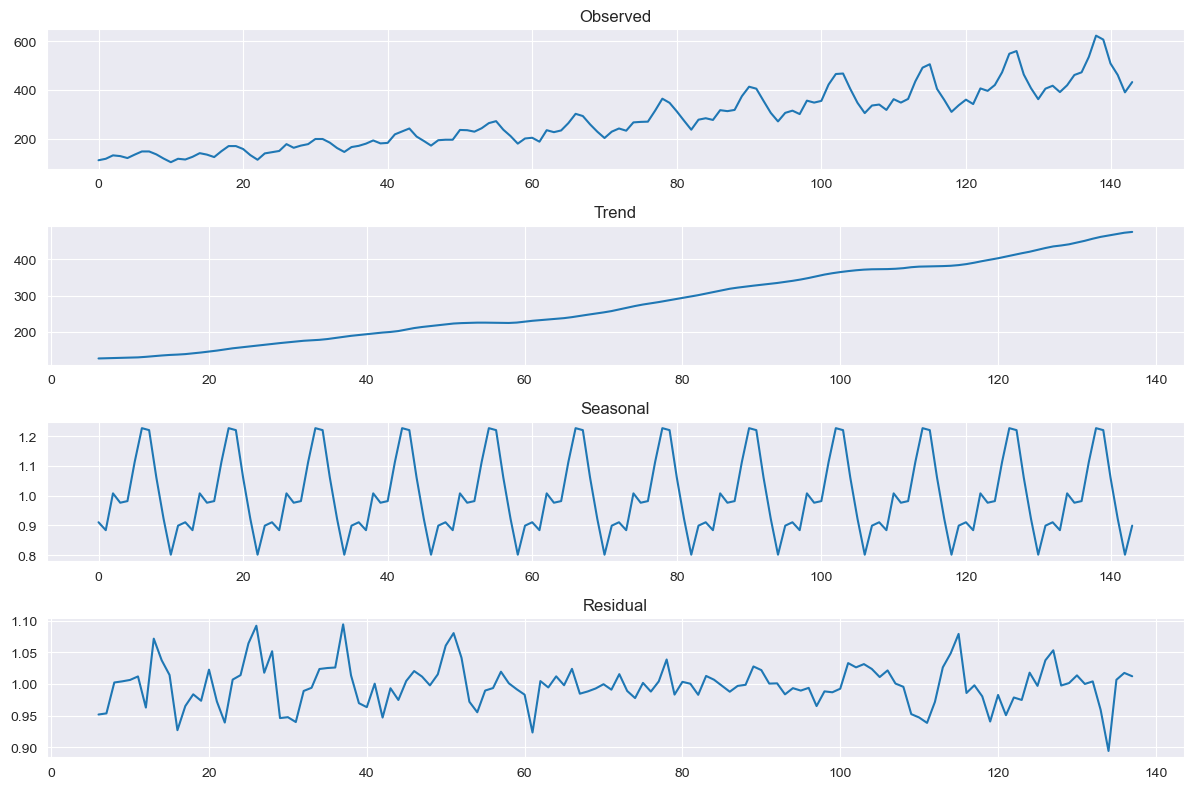

In [14]:
data= df.copy()
# Convert the 'Month' column to datetime and set as index
data['Month_ind'] = pd.to_datetime(data['Month'])
data.set_index('Month_ind', inplace=True)

# Perform seasonal decomposition maybe using a multiplicative model
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative',period=12)

# Plotting the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
plt.tight_layout()

### ADF after seasonal differencing 

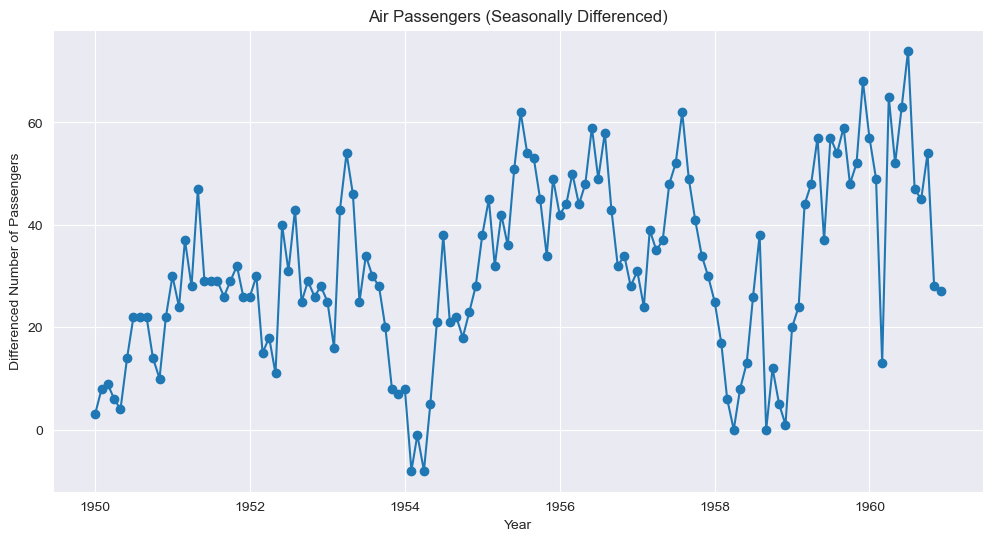

{'ADF Statistic': -3.383020726492481,
 'p-value': 0.011551493085514952,
 'Number of Lags Used': 1,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [15]:
# Seasonal differencing - typically one year (12 months) for monthly data
data_diff = data['Passengers'].diff(12).dropna()

# Perform Augmented Dickey-Fuller test on the differenced data
adf_test_diff = adfuller(data_diff)

# Plot the differenced time series
plt.figure(figsize=(12,6))
plt.plot(data_diff.index, data_diff, marker='o')
plt.title('Air Passengers (Seasonally Differenced)')
plt.xlabel('Year')
plt.ylabel('Differenced Number of Passengers')
plt.grid(True)
plt.show()

# Display ADF test results for the differenced series
adf_test_diff_results = {
    'ADF Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Number of Lags Used': adf_test_diff[2],
    'Number of Observations Used': adf_test_diff[3],
    'Critical Values': adf_test_diff[4]
}

adf_test_diff_results



### Chi2 
by showing that cutting over 12month is a different distribution from flat per month 


Chi-Square Statistic: 292.61636904761906
P-Value: 5.1233345885199216e-21
Degrees of Freedom: 99


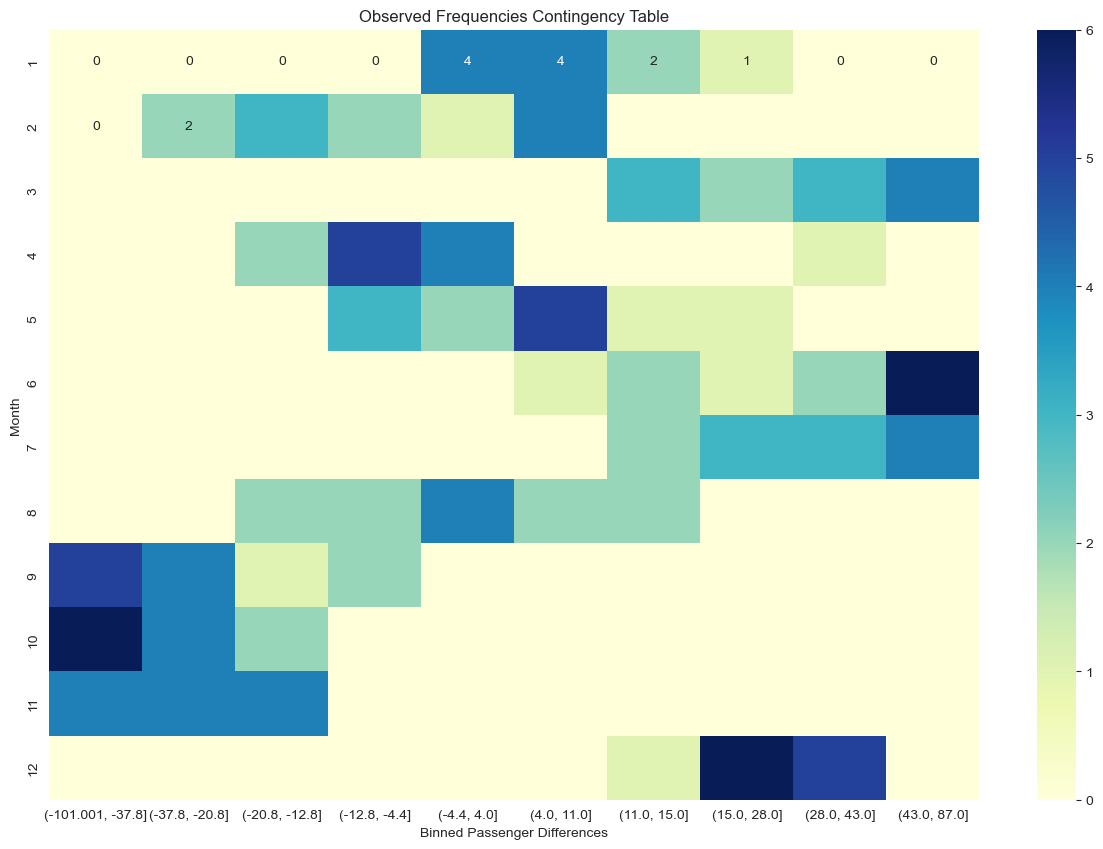

In [16]:
from scipy.stats import chi2_contingency


# Convert 'Month' to datetime and difference the data or 
data['Month'] = pd.to_datetime(data['Month'])
data['Differenced_Passengers'] = data['Passengers'].diff().dropna()

# Extract month and bin the differenced data
data['Month_Only'] = data['Month'].dt.month
number_of_bins = 10
data['Binned_Diff'] = pd.qcut(data['Differenced_Passengers'], number_of_bins)

# Calculate the observed frequencies for each month
observed_frequencies = data.groupby(['Month_Only', 'Binned_Diff']).size().unstack(fill_value=0)

# Calculate the expected frequencies assuming no seasonality
total_counts = data['Binned_Diff'].value_counts()
expected_frequencies = total_counts / 12
expected_frequencies_aligned = pd.DataFrame([expected_frequencies.values]*12, 
                                            columns=expected_frequencies.index, 
                                            index=observed_frequencies.index)

# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(observed_frequencies, expected_frequencies_aligned)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_val)
print("Degrees of Freedom:", dof)

# Plotting the contingency table
plt.figure(figsize=(15, 10))
sns.heatmap(observed_frequencies, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Observed Frequencies Contingency Table')
plt.xlabel('Binned Passenger Differences')
plt.ylabel('Month')
plt.show()

Chi-Square Statistic: 235.54285714285712
P-Value: 3.858075426384456e-13
Degrees of Freedom: 99


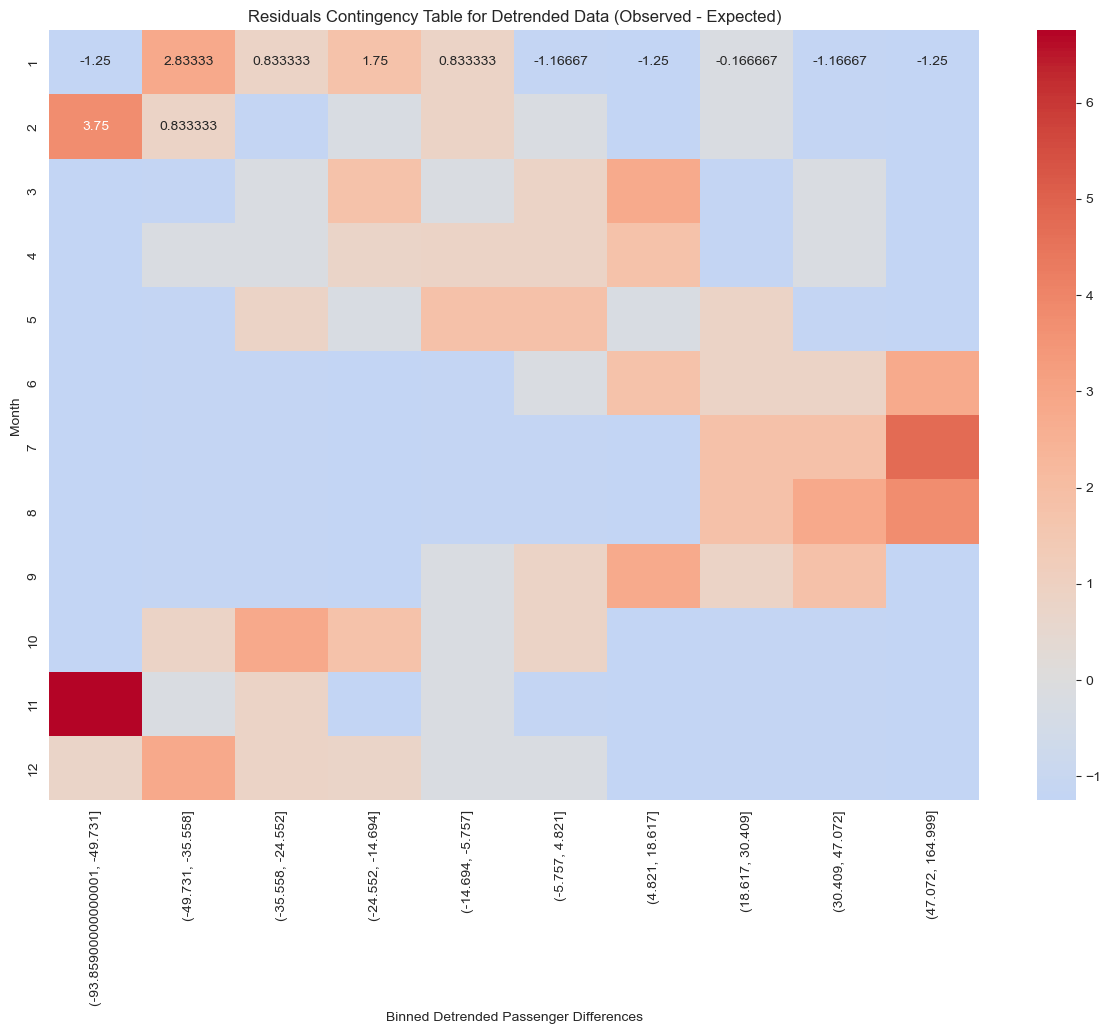

In [17]:
from scipy.signal import detrend

# Apply detrend to the 'Passengers' column
data['Detrended_Passengers'] = detrend(data['Passengers'])

# Re-bin the detrended data (we can use the same number of bins)
data['Binned_Detrended'] = pd.qcut(data['Detrended_Passengers'], number_of_bins)

# Calculate the observed frequencies for each month with the detrended data
observed_frequencies_detrended = data.groupby(['Month_Only', 'Binned_Detrended']).size().unstack(fill_value=0)

# Perform the Chi-Square test on the detrended data
chi2_stat_detrended, p_val_detrended, dof_detrended, expected_detrended = chi2_contingency(observed_frequencies_detrended)

# Calculate residuals for the detrended data (observed - expected)
residuals_detrended = observed_frequencies_detrended - expected_detrended

# Print results for the detrended data
print("Chi-Square Statistic:", chi2_stat_detrended)
print("P-Value:", p_val_detrended)
print("Degrees of Freedom:", dof_detrended)


# Plotting the residuals for the detrended data
plt.figure(figsize=(15, 10))
sns.heatmap(residuals_detrended, annot=True, cmap="coolwarm", fmt='g', center=0)
plt.title('Residuals Contingency Table for Detrended Data (Observed - Expected)')
plt.xlabel('Binned Detrended Passenger Differences')
plt.ylabel('Month')
plt.show()

### Kruskal-Wallis Test

In [47]:
from scipy.stats import kruskal
import calendar
data = df.copy()
# Extract the month from the 'Month' column
data['Month'] = pd.to_datetime(data['Month']).dt.month

# Rename the column for clarity
data.rename(columns={'Month': 'Month_Number'}, inplace=True)

# Convert month numbers to month names for better readability
data['Month'] = data['Month_Number'].apply(lambda _x: calendar.month_abbr[_x])

# Conduct the Kruskal-Wallis test
# We group the data by month and compare the passenger counts
kruskal_results = kruskal(*[group["Passengers"].values for name, group in data.groupby("Month")])

kruskal_results

KruskalResult(statistic=11.148400259640129, pvalue=0.430915880610989)

### Cyclical Indicator Analysis

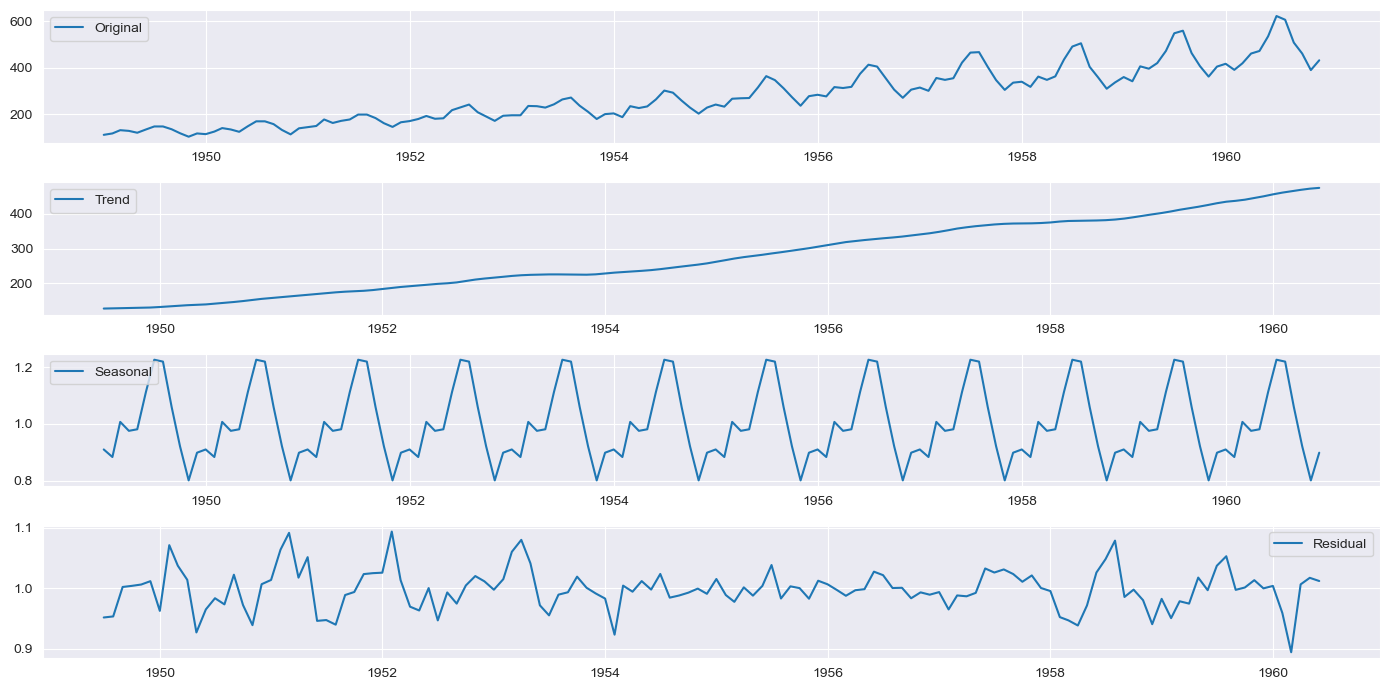

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
data=df.copy()
# Convert 'Month' to datetime
data['Month'] = pd.to_datetime(data['Month'])

# Set 'Month' as the index
data.set_index('Month', inplace=True)

# Decomposing the time series
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative')

plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(data['Passengers'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Return to analysis
we have now defined seasonality as 12

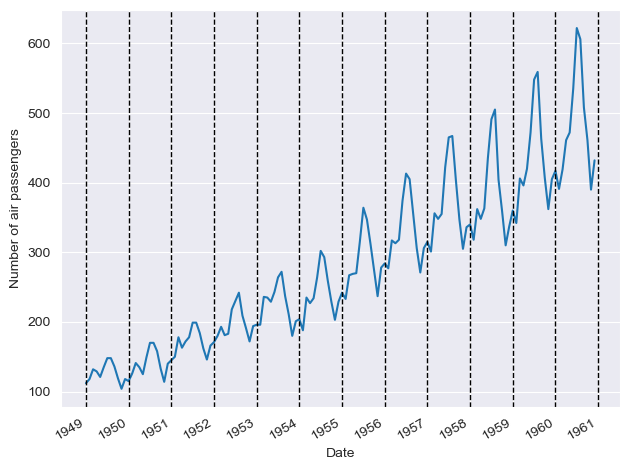

In [18]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()


as usual, we differentiate for stationarity, if we differentiate by seasonality (12) it is stationary but also by 2 for a normal arima process works

In [19]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic df_diff: {ad_fuller_result[0]}')
print(f'p-value df_diff: {ad_fuller_result[1]}')

df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic df_seasonal: {ad_fuller_result[0]}')
print(f'p-value df_seasonal: {ad_fuller_result[1]}')
df_diff2 = np.diff(df_diff, n=1)
ad_fuller_result = adfuller(df_diff2)
print(f'ADF Statistic df_diff2: {ad_fuller_result[0]}')
print(f'p-value df_diff2: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060472
p-value: 0.991880243437641
ADF Statistic df_diff: -2.8292668241700056
p-value df_diff: 0.054213290283824704
ADF Statistic df_seasonal: -17.624862360208162
p-value df_seasonal: 3.823046855816801e-30
ADF Statistic df_diff2: -16.384231542468495
p-value df_diff2: 2.7328918500143186e-29


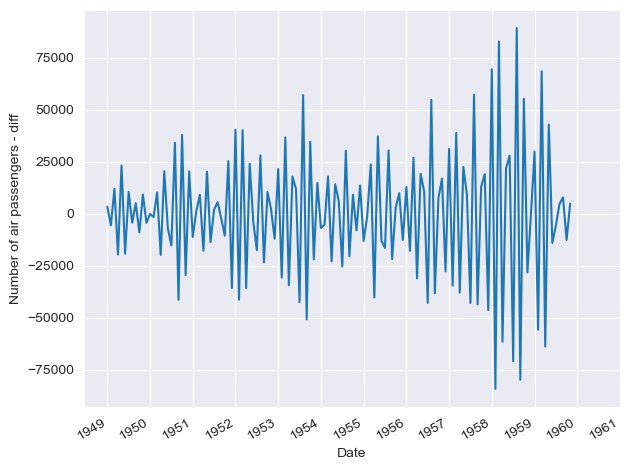

In [20]:
fig, ax = plt.subplots()

ax.plot(df['Month'][13:], df_diff_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers - diff')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

now we want to compare the fit of ARIMA with diff 2 and SARIMA (which includes seasonality) 

In [21]:
def optimize_SARIMA(endog: Union[pd.Series, list], _order_list: list, _d: int, _D: int, _s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try: 
            _model = SARIMAX(
                endog, 
                order=(order[0], _d, order[1]),
                seasonal_order=(order[2], _D, order[3], _s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = _model.aic
        results.append([order, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df_local = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_local

we process with ARIMA then SARIMA to determine best p/q/P/Q

In [22]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)

d = 2

ARIMA_order_list = list(product(ps, qs))

train = df['Passengers'][:-12]

ARIMA_result_df = optimize_ARIMA(train, ARIMA_order_list, d)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(11, 3)",1016.899191
1,"(11, 4)",1019.012587
2,"(12, 0)",1020.256345
3,"(11, 5)",1020.412171
4,"(11, 1)",1021.023615
...,...,...
164,"(5, 0)",1281.732157
165,"(3, 0)",1300.282335
166,"(2, 0)",1302.913196
167,"(1, 0)",1308.152194


In [23]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.255113
1,"(2, 1, 2, 1)",893.620247
2,"(2, 1, 1, 3)",894.099823
3,"(1, 0, 1, 2)",894.287405
4,"(0, 1, 1, 2)",894.993193
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.467899
253,"(0, 0, 3, 0)",908.742583


Now that we have our best models, that is time to check if they are good predictors by checking if residual is as expected gaussian white noise 

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.450
Date:                Mon, 20 Nov 2023   AIC                           1016.899
Time:                        00:54:51   BIC                           1059.912
Sample:                             0   HQIC                          1034.377
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8252      0.100     -8.251      0.000      -1.021      -0.629
ar.L2         -0.9622      0.049    -19.548      0.000      -1.059      -0.866
ar.L3         -0.8511      0.087     -9.740      0.0

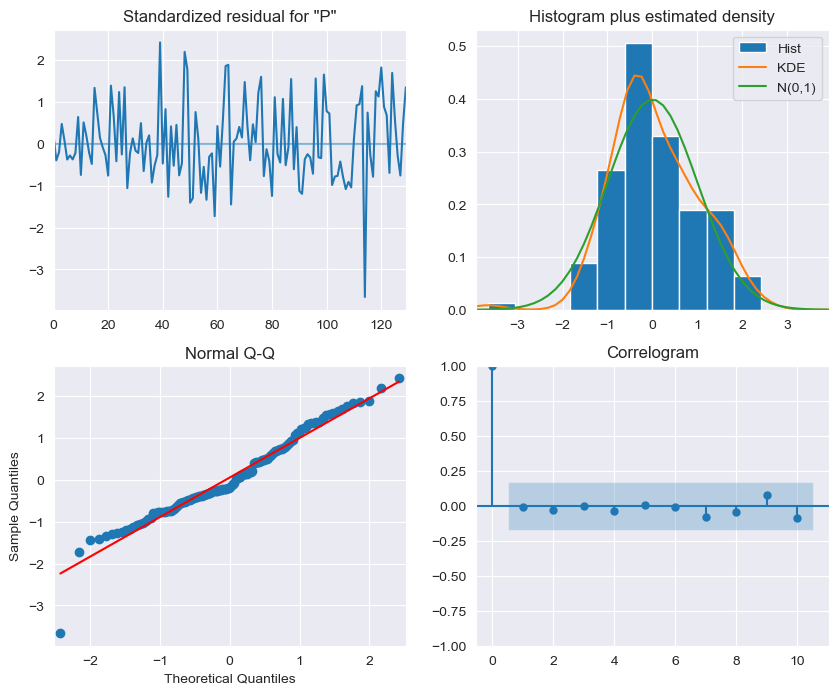

In [24]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))
print(ARIMA_model_fit.summary())
residuals = ARIMA_model_fit.resid
res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(res)

it is interesting because graphs point in the direction of white noise, but ljung box tells us to reject that for lag 1 and 2. It means that our model doesn't capture all the information, some will be stuck in the residual. but that's ok since we already know that we need seasonality, it just confirms what we already knew.

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.128
Date:                                 Mon, 20 Nov 2023   AIC                            892.255
Time:                                         00:54:54   BIC                            911.709
Sample:                                              0   HQIC                           900.155
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2667      0.085    -14.977      0.000      -1.433      -1

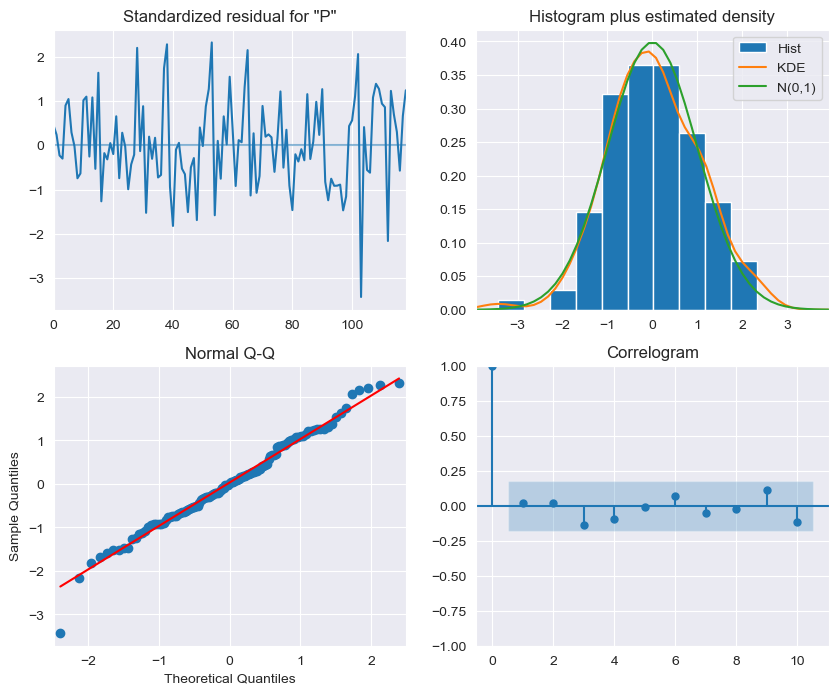

In [25]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
print(SARIMA_model_fit.summary())
residualsS = SARIMA_model_fit.resid
resS = acorr_ljungbox(residualsS, np.arange(1, 11, 1))
print(resS)

then we make the predictions on test dataset 

In [26]:
test = df.iloc[-12:]
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.280018,418.521757
133,1960-02,391,342,410.561106,399.581462
134,1960-03,419,406,461.674397,461.319379
135,1960-04,461,396,457.408559,451.439047
136,1960-05,472,420,481.487254,473.758140
137,1960-06,535,472,530.796211,538.790397
138,1960-07,622,548,606.001512,612.493144
139,1960-08,606,559,615.303598,624.689930
140,1960-09,508,463,525.536903,520.192320
141,1960-10,461,407,467.429180,462.858994


now we print and see that SARIMA is the best performing 

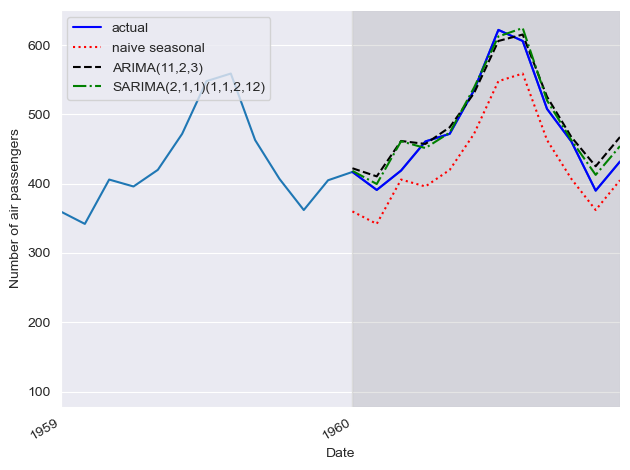

In [27]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()



[9.987532920823485, 3.848242554480648, 2.850813043935041]


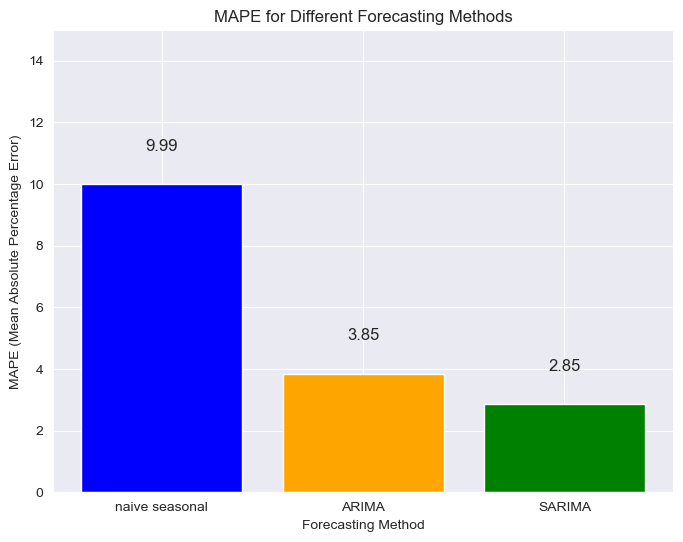

In [34]:

mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])
x = ['naive seasonal', 'ARIMA', 'SARIMA']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
print(y)
plt.figure(figsize=(8, 6))
plt.bar(x, y, color=['blue', 'orange', 'green'])
plt.xlabel('Forecasting Method')
plt.ylabel('MAPE (Mean Absolute Percentage Error)')
plt.title('MAPE for Different Forecasting Methods')
plt.ylim(0, max(y) + 5)  # Adjust the y-axis limit for better visualization

# Display the MAPE values on top of the bars
for i, v in enumerate(y):
    plt.text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


# SARIMA to SARIMAX
Until now, we only considered prediction of a variable (endogenous) as it if were alone. But sometimes a variable is predicted by other variables too (eXogenous). For instance, the country's GDP is predicted by its past values but other variables such as inflation rate or consumption. That is what we will see in this section 


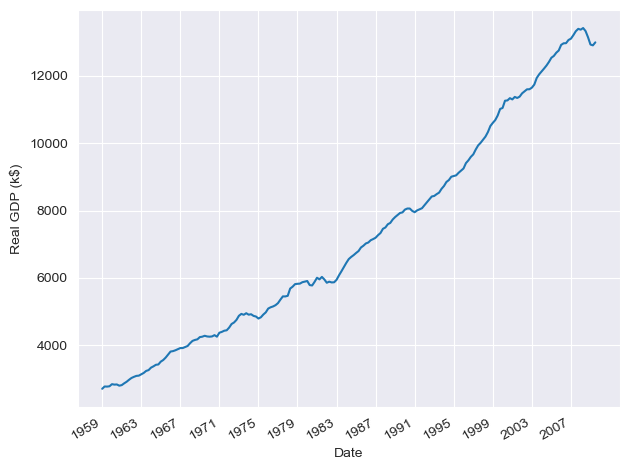

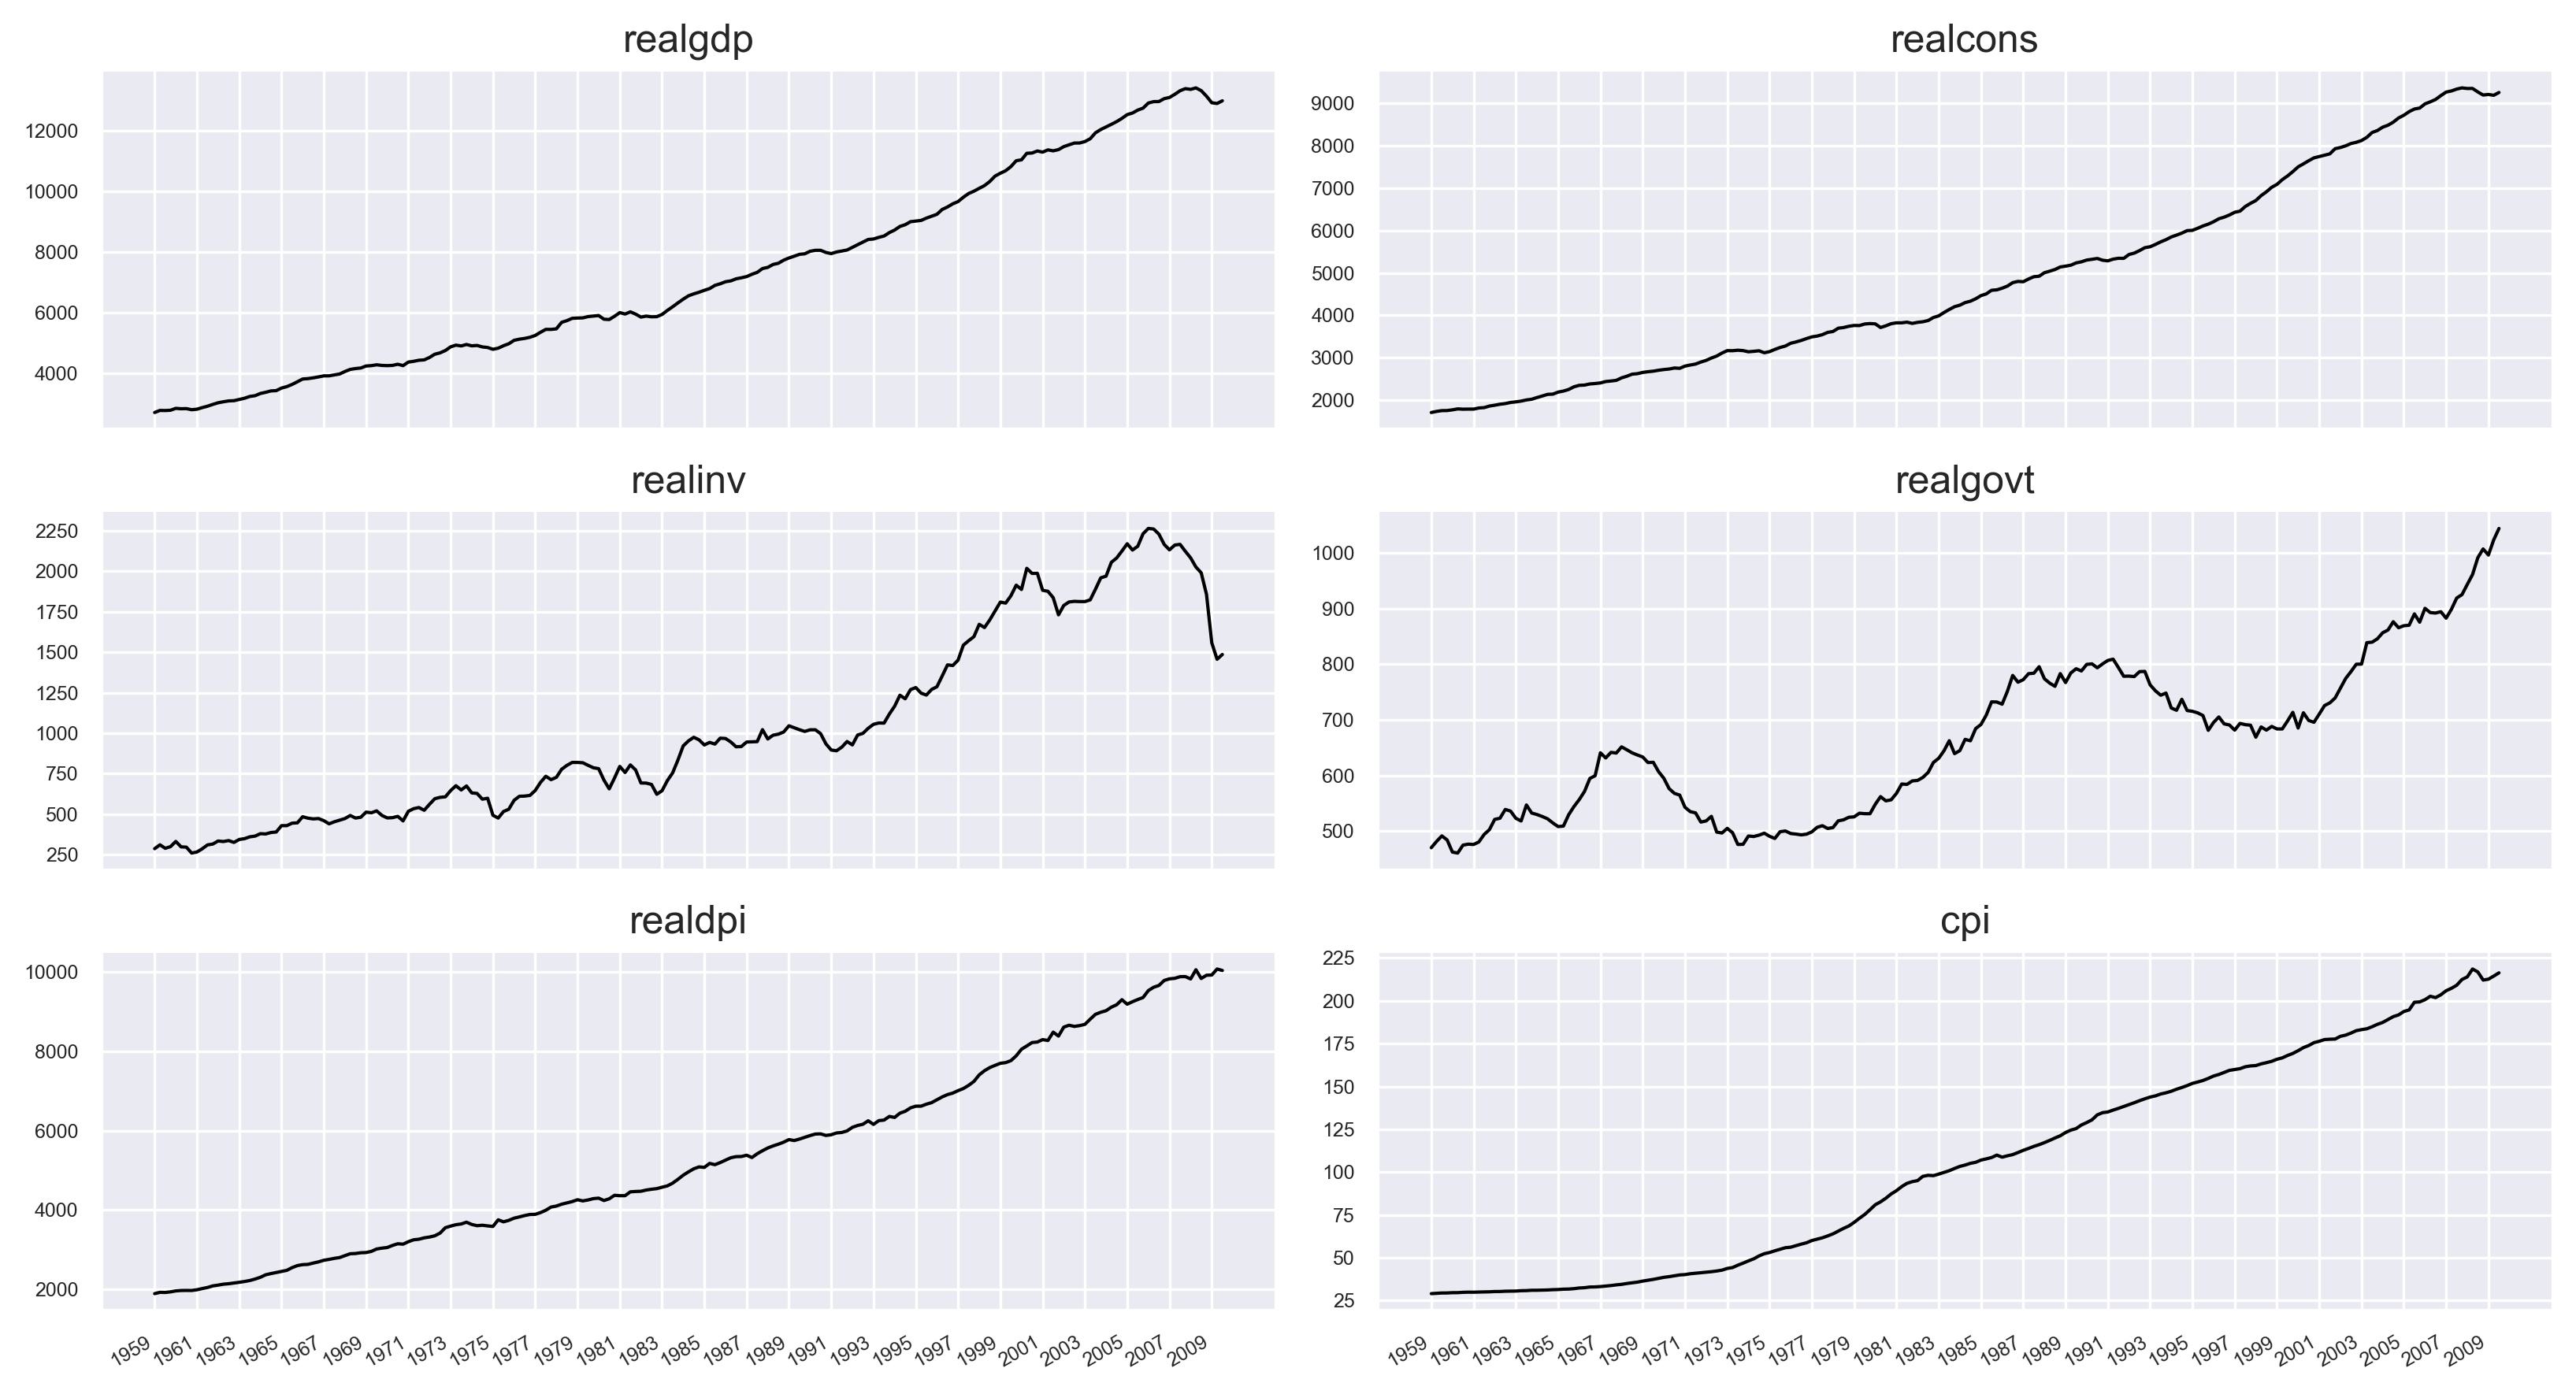

In [40]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()


In [42]:

ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

target_diff = target.diff()
ad_fuller_result = adfuller(target_diff[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647162
p-value: 0.9982455372335032
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [43]:
def optimize_SARIMAX(endog: Union[pd.Series, list], _exog: Union[pd.Series, list], _order_list: list, _d: int, _D: int,
                     _s: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try:
            _model = SARIMAX(
                endog,
                _exog,
                order=(order[0], _d, order[1]),
                seasonal_order=(order[2], _D, order[3], _s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = _model.aic
        results.append([order, aic])

    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df_local = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df_local


In [44]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.410
Date:                Mon, 20 Nov 2023   AIC                           1742.821
Time:                        11:00:04   BIC                           1782.340
Sample:                             0   HQIC                          1758.815
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9698      0.045     21.580      0.000       0.882       1.058
realinv        1.0136      0.033     30.784      0.000       0.949       1.078
realgovt       0.7283      0.127      5.738      0.0

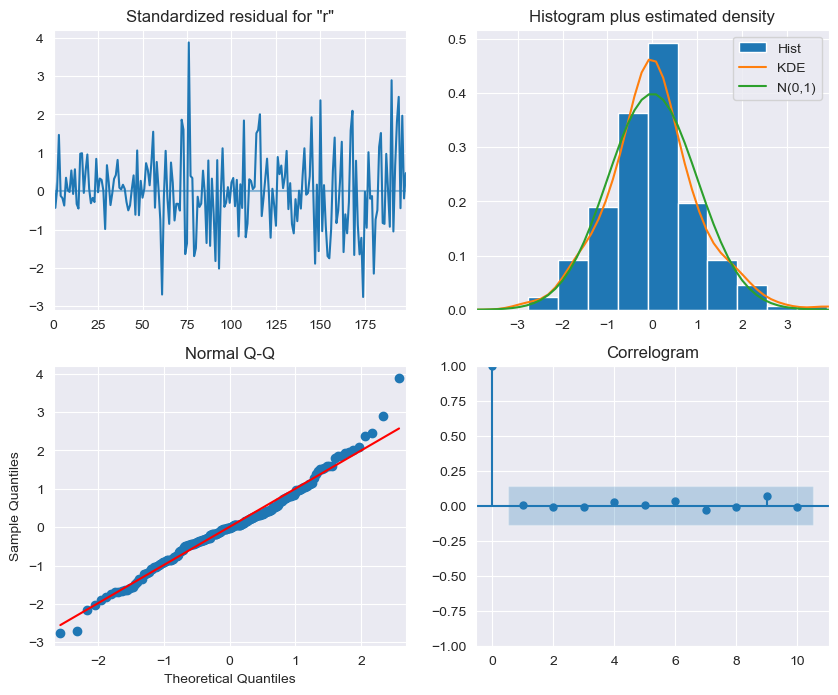

In [49]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(10,8))
print(best_model_fit.summary())

residuals = best_model_fit.resid
value = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(value)

In [50]:
def recursive_forecast(endog: Union[pd.Series, list], _exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        _pred_last_value = []
        
        for j in range(train_len, total_len, window):
            last_value = endog[:j].iloc[-1]
            _pred_last_value.extend(last_value for _ in range(window))
            
        return _pred_last_value
    
    elif method == 'SARIMAX':
        _pred_SARIMAX = []
        
        for j in range(train_len, total_len, window):
            _model = SARIMAX(endog[:j], _exog[:j], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            _res = _model.fit(disp=False)
            predictions = _res.get_prediction(exog=_exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            _pred_SARIMAX.extend(oos_pred)
            
        return _pred_SARIMAX

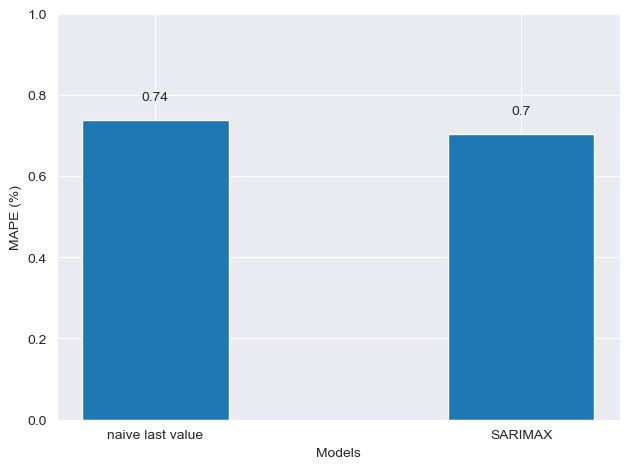

In [60]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

it doesn't seem much, but in reality since we speak about American GDP, it represents a huge amount 

[0.6753839999999981, 0.6436011074130165]


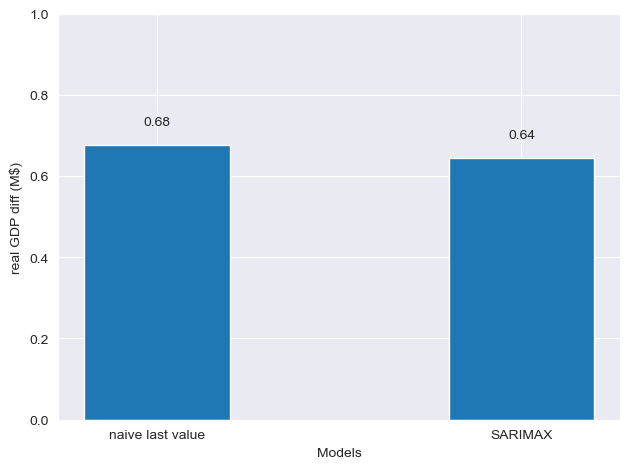

In [61]:
scaling= 1000
abs_last = abs(pred_df.actual-pred_df.pred_last_value)/scaling
abs_SARIMAX = abs(pred_df.actual-pred_df.pred_SARIMAX)/scaling

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [abs_last.sum(), abs_SARIMAX.sum()]
print(y)

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('real GDP diff (M$)')

ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

Still beware that exogenous variables allow you to predict only one step ahead. If you want more steps, you will have to predict also for X-variables which might cumulate inaccuracies 